# Discovery gastronomy diversity in Toronto’s neighbourhood

## I. Introduction: Business Problem

    Toronto is the most populous city in Canada. Toronto also is an international centre of business, finance, arts and culture. It is recognised as one of the most multicultural and cosmopolitan cities in the world. Toronto’s economy is highly diversified with strengths in technology, design, financial services, life sciences, education, fashion, food services and tourism. The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. Torontonians speak English as their primary language, but over 160 languages are spoken in the city.

	The idea of this project is to categorically segment the neighbourhoods of Toronto into major clusters of food habits and taste. By exploring venue data from Foursquare’s ‘Places API’ and using unsupervised machine learning algorithm ‘k-means clustering’, it could help us to discover the diversity of a neighbourhood and its relationship with cuisines in the city.

	This analysis can be used to understand the distribution of different cultures and cuisines over the city. It can also be utilized by a new food vendor who is willing to open his/her restaurant, or by a government who would like to examine and study their city’s culture diversity.

# II. Data

The following data sources will be used in the project:

	1. Toronto dataset:

We firstly use the following wikipedia website to obtain the data that is in the table of postal codes in Toronto: 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
Then, using the following link to a .csv file that has the geographical coordinates of each postal code in Toronto: http://cocl.us/Geospatial_data.

	2. Foursquare API:

Link: https://developer.foursquare.com/docs
Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighbourhoods. This is the link to Foursquare Venue Category Hierarchy. Venues retrieved from all the neighbourhoods are categorised broadly into ‘Arts & Entertainment’, ‘College & University’, ‘Event’, ‘Food’, ‘Nightlife Spot’, ‘Outdoors & Recreation’, ‘Professional and Other’, ‘Residence’, Shop and Service’, ‘Travel and transport’. From which we could extract  food dataset of Toronto’s neighbourhoods.

## III. Methodology

In [50]:
#install
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [115]:
# import libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

 # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


**Download, cleaning Toronto postal code dataset**

In [52]:
Toronto_postcode = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header =0)[0]
Toronto_postcode.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


**Cleaning data**

In [53]:
#  Ignore cells with a borough that is Not assigned.
Toronto_postcode['Borough'].replace('Not assigned', np.nan, inplace=True)
Toronto_postcode.dropna(subset=['Borough'], inplace=True)
Toronto_postcode.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [54]:

# More than one neighborhood can exist in one postal code area.
# These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table

Toronto_postcode = Toronto_postcode.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
Toronto_postcode.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [55]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
Toronto_postcode['Neighbourhood'].replace('Not assigned', Toronto_postcode['Borough'], inplace = True)
Toronto_postcode.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [56]:
Toronto_postcode.shape

(103, 3)

add geo spatial data of Canada

In [57]:
#reading longitude, latitude from data. 
lat_long_df = pd.read_csv('http://cocl.us/Geospatial_data')
lat_long_df.rename(columns={'Postal Code': 'Postcode'}, inplace = True)
lat_long_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [58]:
Toronto_data= pd.merge(Toronto_postcode, lat_long_df, on ='Postcode')
Toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [59]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Toronto_data['Borough'].unique()), Toronto_data.shape[0] ))

The dataframe has 10 boroughs and 103 neighborhoods.


**Use geopy library to get the latitude and longitude values of Toronto, Canada**

In [60]:
#atitude and longitude values of Toronto, Canada
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [61]:
# Create map of Toronto, Canada using latitude and longitude values
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
    
for lat, long, borough, neigh in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Borough'], Toronto_data['Neighbourhood']):
    label = '{},{}'.format(neigh, borough)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=popup,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(Toronto_map)
        
Toronto_map

**Utilizing the Foursquare API to explore the neighborhoods of Toronto**

In [62]:
CLIENT_ID = '41ACGVZWLXPRPCSNGUJBZPVQJ5ZYI3WGIF0MSQ0QQ1GIF4NT'      
CLIENT_SECRET = 'FGOUXEBE2342VDJVIDOKUOHJSVYMTPOUQUSXOAEUVBETZV5R'   
VERSION = '20180901' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 41ACGVZWLXPRPCSNGUJBZPVQJ5ZYI3WGIF0MSQ0QQ1GIF4NT
CLIENT_SECRET:FGOUXEBE2342VDJVIDOKUOHJSVYMTPOUQUSXOAEUVBETZV5R


**Fetch Foursquare Venue Category Hierarch**

In [63]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [64]:
category_results

{'meta': {'code': 200, 'requestId': '5e67b67ab57e88001cb5da1c'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A

In [65]:
category_list = category_results['response']['categories']

In [23]:
#len(category_list)

In [66]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**Now, let's get the Food in Toronto**

In [77]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
    
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        # return only relevant information for each nearby venue
        venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
    


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)


In [79]:

Toronto_venues = getNearbyFood(names=Toronto_data['Neighbourhood'],
                               latitudes=Toronto_data['Latitude'],
                               longitudes=Toronto_data['Longitude'],
                               radius=1000, LIMIT = 500
                              )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

# IV. Data Analysis

In [86]:
print(Toronto_venues.shape)
Toronto_venues.head()

(4291, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop
1,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
2,"Rouge,Malvern",43.806686,-79.194353,Subway,43.801095,-79.200304,Sandwich Place
3,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
4,"Rouge,Malvern",43.806686,-79.194353,McDonald's,43.798261,-79.201449,Fast Food Restaurant


In [87]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 163 uniques categories.


Venue Category
Coffee Shop                      604
Pizza Place                      250
Café                             239
Fast Food Restaurant             194
Restaurant                       189
Bakery                           164
Italian Restaurant               135
Chinese Restaurant               122
Sandwich Place                   105
Caribbean Restaurant              93
Indian Restaurant                 82
Middle Eastern Restaurant         81
Sushi Restaurant                  80
Asian Restaurant                  75
Burger Joint                      75
American Restaurant               72
Breakfast Spot                    71
Food Court                        71
Japanese Restaurant               71
Grocery Store                     68
Thai Restaurant                   66
Deli / Bodega                     54
Vietnamese Restaurant             54
Gastropub                         48
Ice Cream Shop                    45
Mexican Restaurant                42
BBQ Joint              

In [92]:
print('There are {} uniques food categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 163 uniques food categories.


### Analyze Each Neighborhood

In [96]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Belgian Restaurant,Bistro,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Convenience Store,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gaming Cafe,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Pastry Shop,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sports Bar,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yemeni Restaurant
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Rouge,Malvern"

In [97]:
Toronto_onehot.shape

(4291, 164)

In [98]:
# Count venues of each category in each neighborhood
venue_counts = Toronto_onehot.groupby('Neighbourhood').sum()
venue_counts.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Belgian Restaurant,Bistro,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Convenience Store,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gaming Cafe,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Pastry Shop,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sports Bar,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yemeni Restaurant
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0,0,2,0,1,0,0,0,0,2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0
Agincourt,0,0,1,0,2,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,3,0,0,10,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0,0,0,0,3,0,2,0,3,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,3,0,1,0,0,0,10,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",1,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [99]:
# Find out the top 10 food categories in Toronto
venue_counts_described = venue_counts.describe().transpose()

venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Coffee Shop,102.0,5.921569,4.435871,0.0,3.0,5.0,9.0,17.0
Pizza Place,102.0,2.450980,2.232201,0.0,1.0,2.0,4.0,13.0
Café,102.0,2.343137,2.113114,0.0,1.0,2.0,4.0,11.0
Chinese Restaurant,102.0,1.196078,1.965239,0.0,0.0,1.0,1.0,10.0
Middle Eastern Restaurant,102.0,0.794118,1.269117,0.0,0.0,0.0,1.0,10.0
Korean Restaurant,102.0,0.343137,1.138830,0.0,0.0,0.0,0.0,9.0
Greek Restaurant,102.0,0.294118,1.067877,0.0,0.0,0.0,0.0,9.0
Caribbean Restaurant,102.0,0.911765,1.629572,0.0,0.0,0.0,1.0,9.0
Fast Food Restaurant,102.0,1.901961,1.576497,0.0,1.0,2.0,3.0,7.0
Restaurant,102.0,1.852941,1.451507,0.0,1.0,2.0,2.0,7.0


In [101]:
venue_top10_list = venue_top10.index.values.tolist()

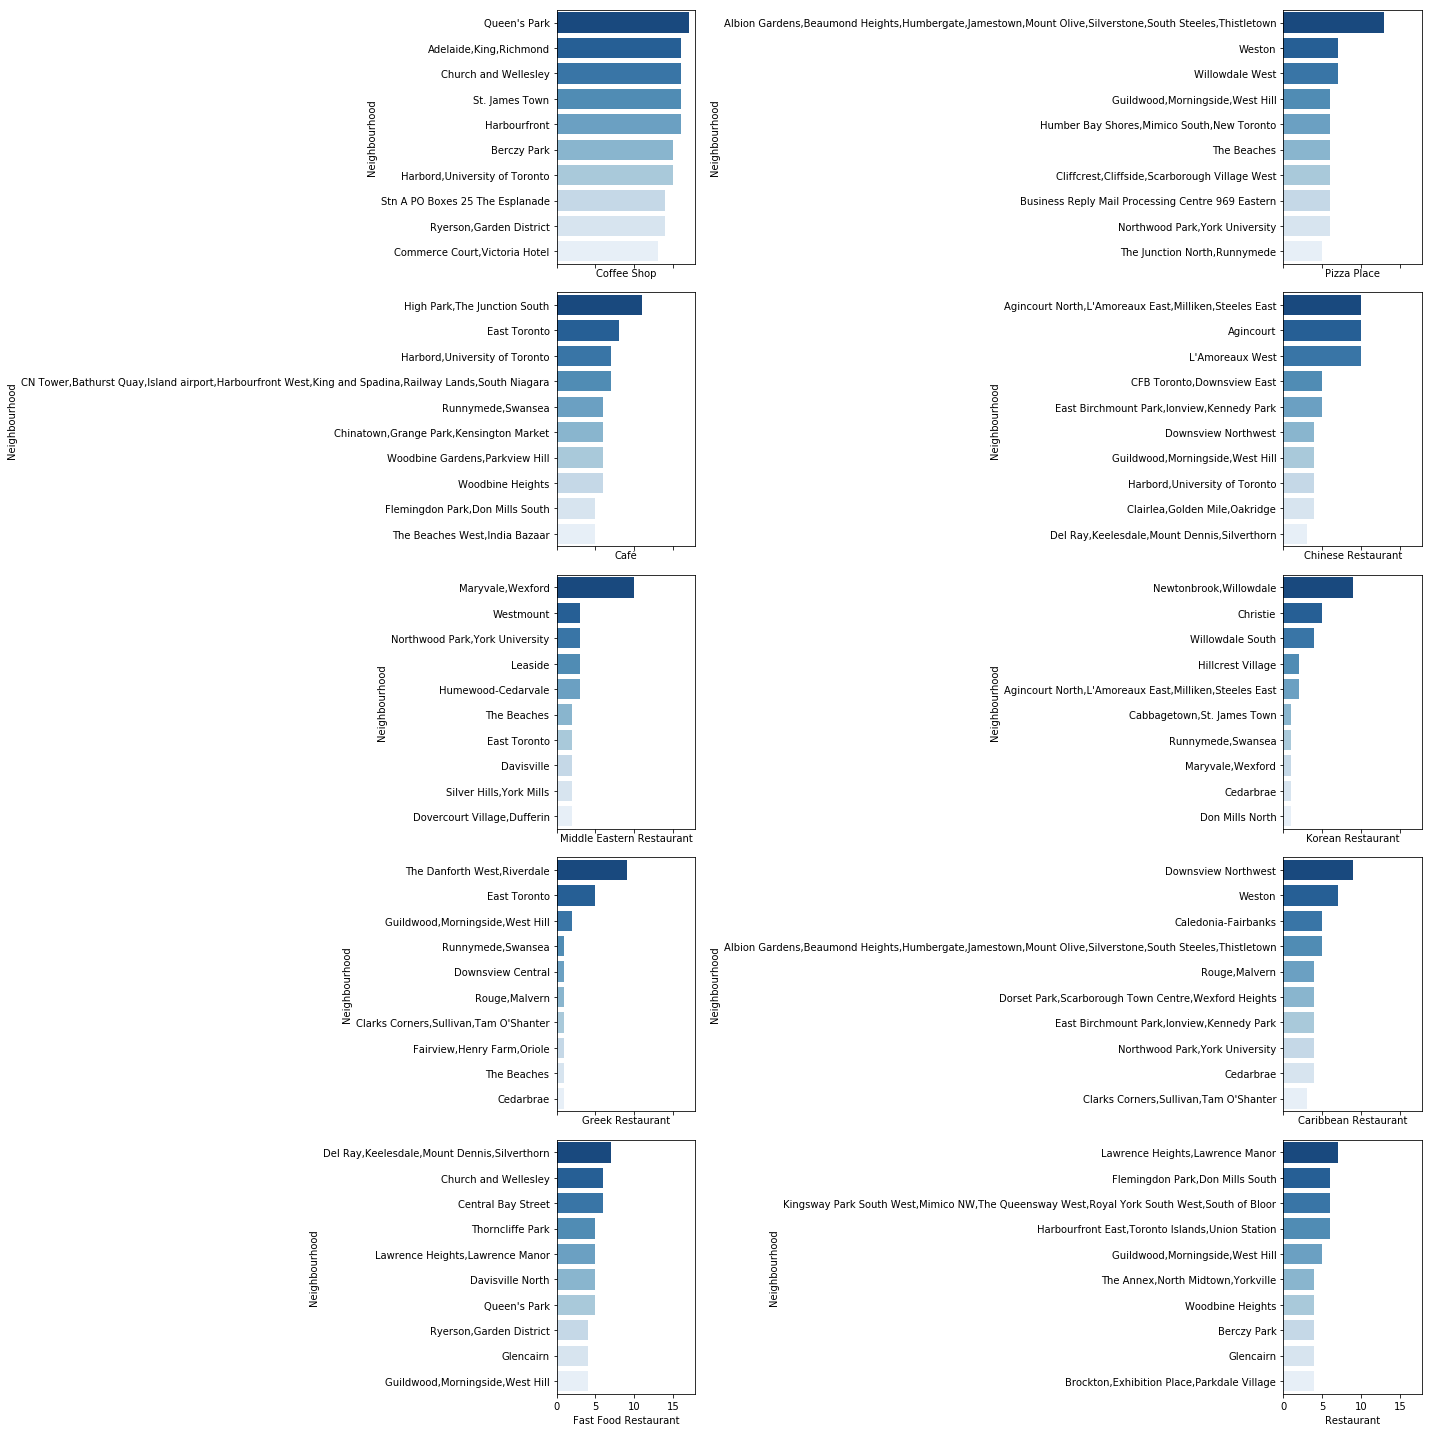

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show()

In [103]:
# Group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Belgian Restaurant,Bistro,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Convenience Store,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gaming Cafe,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Pastry Shop,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sports Bar,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yemeni Restaurant
0,"Adelaide,King,Richmond",0.000000,0.000000,0.040000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.02,0.02,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0

**Write a function to sort the venues in descending order**

In [104]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [140]:
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Food Court,Café,Bar,Deli / Bodega,American Restaurant
1,Agincourt,Chinese Restaurant,Coffee Shop,Caribbean Restaurant,Vietnamese Restaurant,Pizza Place,Asian Restaurant
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Bubble Tea Shop,Noodle House,Café,Asian Restaurant,Bakery
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Bakery,Caribbean Restaurant,Indian Restaurant,Fast Food Restaurant,Grocery Store
4,"Alderwood,Long Branch",Coffee Shop,Café,Italian Restaurant,Restaurant,Pizza Place,Sandwich Place


# V. Machine Learning algorithm: k-means clustering

In [142]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

In [143]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 



array([0, 6, 6, 5, 1, 2, 1, 1, 0, 2], dtype=int32)

In [145]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,0,"Adelaide,King,Richmond",Coffee Shop,Food Court,Café,Bar,Deli / Bodega,American Restaurant
1,6,Agincourt,Chinese Restaurant,Coffee Shop,Caribbean Restaurant,Vietnamese Restaurant,Pizza Place,Asian Restaurant
2,6,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Bubble Tea Shop,Noodle House,Café,Asian Restaurant,Bakery
3,5,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Bakery,Caribbean Restaurant,Indian Restaurant,Fast Food Restaurant,Grocery Store
4,1,"Alderwood,Long Branch",Coffee Shop,Café,Italian Restaurant,Restaurant,Pizza Place,Sandwich Place


In [147]:

Toronto_merged = neighborhoods_venues_sorted.join(Toronto_data.set_index('Neighbourhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
0,0,"Adelaide,King,Richmond",Coffee Shop,Food Court,Café,Bar,Deli / Bodega,American Restaurant,M5H,Downtown Toronto,43.650571,-79.384568
1,6,Agincourt,Chinese Restaurant,Coffee Shop,Caribbean Restaurant,Vietnamese Restaurant,Pizza Place,Asian Restaurant,M1S,Scarborough,43.794200,-79.262029
2,6,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Bubble Tea Shop,Noodle House,Café,Asian Restaurant,Bakery,M1V,Scarborough,43.815252,-79.284577
3,5,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Bakery,Caribbean Restaurant,Indian Restaurant,Fast Food Restaurant,Grocery Store,M9V,Etobicoke,43.739416,-79.588437
4,1,"Alderwood,Long Branch",Coffee Shop,Café,Italian Restaurant,Restaurant,Pizza Place,Sandwich Place,M8W,Etobicoke,43.602414,-79.543484


In [148]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# VI. Results

In [149]:
required_column_indices = [2,3,7]
required_column = [list(Toronto_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

**Cluster 0**

In [150]:
cluster_0 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[1:12]]
cluster_0.head(5)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
0,"Adelaide,King,Richmond",Coffee Shop,Food Court,Café,Bar,Deli / Bodega,American Restaurant,M5H,Downtown Toronto,43.650571,-79.384568
8,Berczy Park,Coffee Shop,Food Court,Restaurant,Café,American Restaurant,Bar,M5E,Downtown Toronto,43.644771,-79.373306
15,"Cabbagetown,St. James Town",Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Gastropub,Ramen Restaurant,Restaurant,M4X,Downtown Toronto,43.667967,-79.367675
19,Central Bay Street,Coffee Shop,Fast Food Restaurant,Food Court,Café,Burger Joint,American Restaurant,M5G,Downtown Toronto,43.657952,-79.387383
22,Church and Wellesley,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Burger Joint,Gastropub,Ramen Restaurant,M4Y,Downtown Toronto,43.665860,-79.383160


In [151]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Coffee Shop    15
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Food Court              7
Fast Food Restaurant    4
Café                    2
Japanese Restaurant     1
Restaurant              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    4
American Restaurant     3
Ramen Restaurant        2
Restaurant              2
Bar                     1
Food Court              1
Deli / Bodega           1
Diner                   1
Name: 6th Most Common Venue, dtype: int64
---------------------------------------------


**Cluster 1**

In [152]:
cluster_1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[1:12]]
cluster_1.head(5)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
4,"Alderwood,Long Branch",Coffee Shop,Café,Italian Restaurant,Restaurant,Pizza Place,Sandwich Place,M8W,Etobicoke,43.602414,-79.543484
6,Bayview Village,Café,Asian Restaurant,Japanese Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,M2K,North York,43.786947,-79.385975
7,"Bedford Park,Lawrence Manor East",Italian Restaurant,Coffee Shop,Pizza Place,Fast Food Restaurant,Bakery,Sandwich Place,M5M,North York,43.733283,-79.419750
13,"CFB Toronto,Downsview East",Coffee Shop,Bakery,Chinese Restaurant,Turkish Restaurant,Italian Restaurant,Restaurant,M3K,North York,43.737473,-79.464763
17,Canada Post Gateway Processing Centre,Coffee Shop,Burger Joint,Pizza Place,Bakery,Mexican Restaurant,Asian Restaurant,M7R,Mississauga,43.636966,-79.615819


In [153]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Café                         8
Coffee Shop                  6
Italian Restaurant           3
Bakery                       2
Sushi Restaurant             1
Greek Restaurant             1
Korean Restaurant            1
Middle Eastern Restaurant    1
Pizza Place                  1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop           8
Pizza Place           5
Italian Restaurant    2
Café                  2
Bakery                2
Indian Restaurant     1
Greek Restaurant      1
Burger Joint          1
Breakfast Spot        1
Asian Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Asian Restaurant             3
Sandwich Place               3
Fast Food Restaurant         2
Restaurant                   2
Chinese Restaurant           1
Vietnamese Restaurant        1
Brazilian Restaurant         1
Middle Eastern Restaurant    1
Pizza Place                  1
Italian Restaurant        

**Cluster 2**

In [154]:
cluster_2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[1:12]]
cluster_2.head(5)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
5,"Bathurst Manor,Downsview North,Wilson Heights",Ice Cream Shop,Pizza Place,Middle Eastern Restaurant,Coffee Shop,Deli / Bodega,Fried Chicken Joint,M3H,North York,43.754328,-79.442259
9,"Birch Cliff,Cliffside West",Indian Restaurant,Diner,Restaurant,Ice Cream Shop,Thai Restaurant,Pizza Place,M1N,Scarborough,43.692657,-79.264848
33,Don Mills North,Coffee Shop,Japanese Restaurant,Thai Restaurant,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,M3B,North York,43.745906,-79.352188
36,Downsview Central,Vietnamese Restaurant,Restaurant,Coffee Shop,Latin American Restaurant,Pizza Place,Greek Restaurant,M3M,North York,43.728496,-79.495697
43,"Fairview,Henry Farm,Oriole",Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,M2J,North York,43.778517,-79.346556


In [155]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Coffee Shop                  3
Restaurant                   3
Italian Restaurant           1
Indian Restaurant            1
Bubble Tea Shop              1
Vietnamese Restaurant        1
Middle Eastern Restaurant    1
Ice Cream Shop               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    4
Restaurant              3
Japanese Restaurant     1
Coffee Shop             1
Pizza Place             1
Deli / Bodega           1
Diner                   1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Food Truck                   1
Latin American Restaurant    1
Chinese Restaurant           1
Ice Cream Shop               1
Pizza Place                  1
Mediterranean Restaurant     1
Greek Restaurant             1
Restaurant                   1
Middle Eastern Restaurant    1
Fried Chicken Joint          1
Asian Restaurant             1
Sandwich Place               1
Name: 6th Most Common 

**Cluster 3**

In [156]:
cluster_3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[1:12]]
cluster_3.head(5)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
59,Islington Avenue,Cupcake Shop,Fast Food Restaurant,Pizza Place,Café,Bakery,Egyptian Restaurant,M9A,Etobicoke,43.667856,-79.532242


In [157]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Cupcake Shop    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Egyptian Restaurant    1
Name: 6th Most Common Venue, dtype: int64
---------------------------------------------


**Cluster 4**

In [158]:
cluster_4 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[1:12]]
cluster_4.head(5)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
11,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Bakery,Restaurant,Café,Tibetan Restaurant,Beer Bar,M6K,West Toronto,43.636847,-79.428191
14,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Coffee Shop,Café,Bubble Tea Shop,Sandwich Place,Restaurant,Diner,M5V,Downtown Toronto,43.628947,-79.394420
20,"Chinatown,Grange Park,Kensington Market",Coffee Shop,Café,Ramen Restaurant,Fast Food Restaurant,Thai Restaurant,Diner,M5T,Downtown Toronto,43.653206,-79.400049
21,Christie,Coffee Shop,Café,Korean Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,M6G,Downtown Toronto,43.669542,-79.422564
28,Davisville,Coffee Shop,Fast Food Restaurant,Pizza Place,Thai Restaurant,Wings Joint,Italian Restaurant,M4S,Central Toronto,43.704324,-79.388790


In [159]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Coffee Shop           17
African Restaurant     1
Café                   1
Bakery                 1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Café                         6
Coffee Shop                  2
Fast Food Restaurant         2
Bakery                       2
Italian Restaurant           1
Latin American Restaurant    1
Bubble Tea Shop              1
Breakfast Spot               1
Sushi Restaurant             1
Deli / Bodega                1
Pizza Place                  1
Caribbean Restaurant         1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Sushi Restaurant             4
Beer Bar                     2
Diner                        2
Restaurant                   2
Bar                          1
Italian Restaurant           1
Chinese Restaurant           1
Fast Food Restaurant         1
Dessert Shop                 1
Latin American Restaurant    1
Mediterranean Restaurant     1
Middle East

**Cluster 5**

In [160]:
cluster_5 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[1:12]]
cluster_5.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Bakery,Caribbean Restaurant,Indian Restaurant,Fast Food Restaurant,Grocery Store,M9V,Etobicoke,43.739416,-79.588437
10,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Pizza Place,Coffee Shop,Grocery Store,Chinese Restaurant,Eastern European Restaurant,Fish & Chips Shop,M9C,Etobicoke,43.643515,-79.577201
12,Business Reply Mail Processing Centre 969 Eastern,Pizza Place,Coffee Shop,Bakery,Sandwich Place,Café,Fast Food Restaurant,M7Y,East Toronto,43.662744,-79.321558
16,Caledonia-Fairbanks,Caribbean Restaurant,Pizza Place,Portuguese Restaurant,Bakery,Latin American Restaurant,French Restaurant,M6E,York,43.689026,-79.453512
18,Cedarbrae,Bakery,Indian Restaurant,Coffee Shop,Caribbean Restaurant,Pizza Place,Restaurant,M1H,Scarborough,43.773136,-79.239476


In [161]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place             15
Caribbean Restaurant     3
Coffee Shop              3
Asian Restaurant         1
Fast Food Restaurant     1
Bakery                   1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop             7
Pizza Place             4
Fast Food Restaurant    3
Sandwich Place          2
Indian Restaurant       2
Caribbean Restaurant    2
Chinese Restaurant      1
Breakfast Spot          1
Restaurant              1
Bakery                  1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant         3
Fast Food Restaurant       3
Fish & Chips Shop          2
Burger Joint               2
Deli / Bodega              2
Fried Chicken Joint        2
Filipino Restaurant        1
Coffee Shop                1
Ethiopian Restaurant       1
French Restaurant          1
Breakfast Spot             1
Mexican Restaurant         1
Grocery Store              1
Restaurant               

**Cluster 6**

In [162]:
cluster_6 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[1:12]]
cluster_6.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
1,Agincourt,Chinese Restaurant,Coffee Shop,Caribbean Restaurant,Vietnamese Restaurant,Pizza Place,Asian Restaurant,M1S,Scarborough,43.794200,-79.262029
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Bubble Tea Shop,Noodle House,Café,Asian Restaurant,Bakery,M1V,Scarborough,43.815252,-79.284577
23,"Clairlea,Golden Mile,Oakridge",Chinese Restaurant,Bakery,Pizza Place,Restaurant,Indian Restaurant,Diner,M1L,Scarborough,43.711112,-79.284577
54,Hillcrest Village,Pizza Place,Chinese Restaurant,Korean Restaurant,Restaurant,Bakery,Coffee Shop,M2H,North York,43.803762,-79.363452
62,L'Amoreaux West,Chinese Restaurant,Indian Restaurant,Bakery,Fast Food Restaurant,BBQ Joint,Coffee Shop,M1W,Scarborough,43.799525,-79.318389


In [163]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant    4
Pizza Place           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Bubble Tea Shop       1
Indian Restaurant     1
Chinese Restaurant    1
Coffee Shop           1
Bakery                1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop         2
Asian Restaurant    1
Diner               1
Bakery              1
Name: 6th Most Common Venue, dtype: int64
---------------------------------------------


**Cluster 7**

In [164]:
cluster_7 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 7, Toronto_merged.columns[1:12]]
cluster_7.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,Postcode,Borough,Latitude,Longitude
38,Downsview West,Vietnamese Restaurant,Pizza Place,Portuguese Restaurant,Caribbean Restaurant,Chinese Restaurant,Italian Restaurant,M3L,North York,43.739015,-79.506944


In [165]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Vietnamese Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant    1
Name: 6th Most Common Venue, dtype: int64
---------------------------------------------


# VII. Discussion

See Report file

# VIII. Conclusion

See report file